### 1. Requirements


tensorflow==1.7.1

Pillow>=4.2.1

matplotlib

numpy==1.13.3

jupyter

jupyter-console==5.2.0

prompt-toolkit==1.0.18

tensorflow-tensorboard==0.1.8

pytest>=3.2.2

docopt

pyyaml

protobuf==3.5.2

grpcio==1.11.0

torch==0.4.0

pandas

scipy

ipykernel



In [1]:
!pip -q install ./python

In [2]:
import numpy as np
import random

import torch
from collections import deque
from unityagents import UnityEnvironment

from agent import Agent
from model import QNetwork

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Start the Environment

In [3]:
# Start the environment already saved in the workspace
# Environments contain brains which are responsible for deciding the actions of their associated agents. 
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# Check for the first brain available, and set it as the default brain we will be controlling from Python.
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# Print out some information about the environment.

# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Train the agent

In [6]:
def navigate_train(n_episode=2000, max_t = 1000, eps_start = 1.0, eps_end = 0.01, eps_decay = 0.999, train = True, ckpth = 'checkpoint_navigation.pth'):

#def navigate_train(agent, n_episode=1500, max_t = 1000, eps_start = 1.0, eps_end = 0.01, eps_decay = 0.999, train = True, ckpth = 'checkpoint_navigation.pth'):
    scores = []
    moving_avgs =[]
    scores_window = deque(maxlen = 100)
    eps = eps_start
    for i_episode in range(1, n_episode+1):
        env_info = env.reset(train_mode=train)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps if train else 0.0) # select an action
            env_info = env.step(action)[brain_name]          # send the action to the environment
            next_state = env_info.vector_observations[0]     # get the next state
            reward = env_info.rewards[0]                     # get the reward
            done = env_info.local_done[0]                    # see if episode has finished
            if train:                                        # if ...
                agent.step(state, action, reward, next_state, done)
            score += reward                                  # update the score
            state = next_state                               # roll over the state to next time step
            if done:                                          # exit loop if episode finished
                break
        scores.append(score)
        scores_window.append(score)
        moving_avg = np.mean(scores_window)
        moving_avgs.append(moving_avg)
        eps = max(eps_end, eps * eps_decay)
        if i_episode % 100 == 0:
            print('\rEpisode {:d}\tAverage score: {:2f}'.format(i_episode, moving_avg))
        # 2 point of margin vs target
        if moving_avg >= 15.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:f}'.format(i_episode-100, moving_avg))
            if train:
                torch.save(agent.qnetwork_local.state_dict(), ckpth)
            break
        if i_episode % 1000 == 0:
            torch.save(agent.qnetwork_local.s+tate_dict(), ckpth)
    
    return scores, moving_avgs

Episode 100	Average score: 3.580000
Episode 200	Average score: 8.510000
Episode 300	Average score: 11.780000
Episode 400	Average score: 13.480000
Episode 500	Average score: 15.000000

Environment solved in 400 episodes!	Average Score: 15.000000


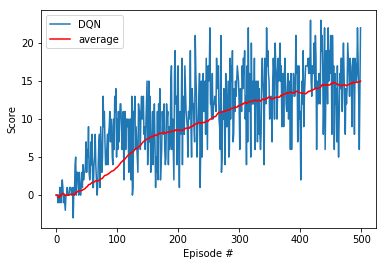

In [7]:
# train and save agent weights
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
scores, avgs = navigate_train(n_episode=2000, eps_decay=0.98, eps_end=0.02, ckpth='checkpoint_navigation.pth')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DQN')
plt.plot(np.arange(len(scores)), avgs, c='r', label='average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

### 4. Test the agent

Episode 1	Average Score: 12.000000
Episode 2	Average Score: 14.500000
Episode 3	Average Score: 16.666667
Episode 4	Average Score: 16.250000
Episode 5	Average Score: 15.600000


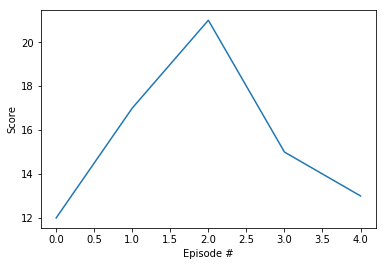

In [8]:
# test the saved agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
ckpth = 'checkpoint_navigation.pth'
agent.qnetwork_local.load_state_dict(torch.load(ckpth))
n_episodes = 5
scores = []
for i_episode in range(1, n_episodes + 1):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    while True:
        action = agent.act(state, eps = 0.0)           # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            scores.append(score)
            print('\rEpisode {}\tAverage Score: {:f}'.format(i_episode, np.mean(scores)))
            break
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()    

### 5. Close the environment

In [9]:
env.close()

### 6. Future works

Try Dueling Networks, Reply Buffer and Noisy DQN